# Imports

In [1]:
import ipywidgets as widgets
from IPython.display import clear_output, display, Image
import os
import sys
import copy
import pickle

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont

from scipy.spatial.transform import Rotation as R

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.ops import box_convert
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [3]:
HOME = os.getcwd()
print(HOME)

/home2/kumaradi.gupta/instance-map


In [4]:
#RAM Imports
from ram.models import ram
from ram import inference_ram as inference

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate

import supervision as sv

# Segment Anything
from segment_anything import build_sam, SamPredictor

#Embeddings
from typing import Literal
import einops
import clip

In [5]:
from tqdm.notebook import tqdm

In [6]:
import gc

# Setup

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
weights_dir = "/scratch/laksh.nanwani/checkpoints"

# imgs_dir = "/scratch/laksh.nanwani/instance_slam/JmbYfDe2QKZ/rgb"
# depth_dir = "/scratch/laksh.nanwani/instance_slam/JmbYfDe2QKZ/depth/"
# pose_dir = "/scratch/laksh.nanwani/instance_slam/JmbYfDe2QKZ/pose/"

imgs_dir = "/scratch/kumaradi.gupta/run_kinect_wheel_1/rgb"
depth_dir = "/scratch/kumaradi.gupta/run_kinect_wheel_1/depth/"
pose_dir = "/scratch/kumaradi.gupta/run_kinect_wheel_1/pose/"

In [9]:
# req_tags = ["table", "chair", "stool", "fan", "computer", 'stool', 
#             'pillar', 'couch', 'door', 'art', 'bed', 'bookshelf', 'picture', 'frame', 
#             'appliance', 'box', 'cabinet', 'wall','cubicle', 'pillar', 'equipment', 
#             'clock', 'board']

# colors = [
#     (255, 105, 97),  # Pastel Red
#     (255, 179, 71),  # Pastel Orange
#     (253, 253, 150), # Pastel Yellow
#     (119, 221, 119), # Pastel Green
#     (203, 153, 201), # Pastel Purple
#     (174, 198, 207), # Pastel Blue
#     (255, 209, 220), # Pastel Pink
#     (128, 128, 128), # Grey
#     (255, 0, 255),   # Magenta
#     (0, 0, 255),     # Blue
#     (0, 255, 255),   # Cyan
#     (255, 0, 0),     # Red
#     (139, 69, 19),   # Saddle Brown
#     (255, 140, 0),   # Dark Orange
#     (128, 0, 0),     # Maroon
#     (75, 0, 130),    # Indigo
#     (173, 216, 230), # Light Blue
#     (144, 238, 144), # Light Green
#     (255, 192, 203), # Pink
#     (210, 105, 30),  # Chocolate
#     (106, 90, 205),  # Slate Blue
#     (255, 165, 0),   # Orange
#     (70, 130, 180),  # Steel Blue
# ]

req_tags = ['chair', 'cupboard', 'stool', 'table', 'fan', 'door']
colors = [
    (255, 105, 97),  # Pastel Red
    (253, 253, 150), # Pastel Yellow
    (119, 221, 119), # Pastel Green
    (203, 153, 201), # Pastel Purple
    (174, 198, 207), # Pastel Blue
    (255, 209, 220), # Pastel Pink
]


def normalize_color(color_255):
    return tuple(val/255.0 for val in color_255)

# RAM Load + Run

In [10]:
image_size = 384 # default value
pretrained = f"{weights_dir}/ram_swin_large_14m.pth"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(), normalize
])

#Load model
ram_model = ram(pretrained=pretrained,
                          image_size=image_size,
                          vit='swin_l')
ram_model.eval()

ram_model = ram_model.to(device)

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
/scratch/laksh.nanwani/checkpoints/ram_swin_large_14m.pth
--------------
load checkpoint from /scratch/laksh.nanwani/checkpoints/ram_swin_large_14m.pth
vit: swin_l


In [11]:
img_files = [f for f in os.listdir(imgs_dir) if os.path.isfile(os.path.join(imgs_dir, f))]

img_dict = {}

# # Loop through each image file
for i, img_file in enumerate(tqdm(img_files)):
    img_id = os.path.splitext(img_file)[0]
    img_path = os.path.join(imgs_dir, img_file)
    raw_image = Image.open(img_path).convert("RGB").resize((image_size, image_size))
    image = transform(raw_image).unsqueeze(0).to(device)

    ram_tags = inference(image, ram_model)[0]
    ram_tags = ram_tags.split(' | ') # Split the tags
    ram_tags = [tag.split() for tag in ram_tags] # Split the tags into words
    ram_tags = [item for sublist in ram_tags for item in sublist] # Flatten the list
    ram_tags = list(set(ram_tags) & set(req_tags)) # Get the intersection of the tags
    ram_tags = " . ".join(str(tag) for tag in ram_tags) # Join the tags with a period
    # print(ram_tags)

    # Add the img_path and ram_tags to the dictionary
    img_dict[img_id] = {'img_path': img_path, 'ram_tags': ram_tags, 'objs': {}}

  0%|          | 0/893 [00:00<?, ?it/s]

In [13]:
# print(img_dict['JmbYfDe2QKZ_1'])
print(img_dict['1'])

{'img_path': '/scratch/kumaradi.gupta/run_kinect_wheel_1/rgb/1.jpg', 'ram_tags': 'stool . chair . table', 'objs': {}}


In [14]:
del ram_model
torch.cuda.empty_cache()
gc.collect()

50

# GDINO + SAM Load and Run

In [15]:
CONFIG_PATH = f"{HOME}/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_NAME_GD = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH_GD = f"{weights_dir}/{WEIGHTS_NAME_GD}"
print(WEIGHTS_PATH_GD, "; exist:", os.path.isfile(WEIGHTS_PATH_GD))

/home2/kumaradi.gupta/instance-map/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/scratch/laksh.nanwani/checkpoints/groundingdino_swint_ogc.pth ; exist: True


In [16]:
#Load Model Grounding DINO
GDINO_model = load_model(CONFIG_PATH, WEIGHTS_PATH_GD)

final text_encoder_type: bert-base-uncased


In [17]:
sam_checkpoint_name = "sam_vit_h_4b8939.pth"
sam_checkpoint = f"{weights_dir}/{sam_checkpoint_name}"
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

In [18]:
# SAM Functions

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()

# For drawing SAM Mask
def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [19]:
BOX_TRESHOLD = 0.37
TEXT_TRESHOLD = 0.37

for img_id, img_data in tqdm(img_dict.items()):
    img_path = img_data['img_path']

    TEXT_PROMPT = img_dict[img_id]['ram_tags']
    image_source, image = load_image(img_path)

    # Get DINO Bounding Boxes
    boxes, logits, phrases = predict(
        model=GDINO_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    # print(boxes)

    if boxes.nelement() == 0:
        continue

    # Get SAM Masks
    sam_image = cv2.imread(img_path)
    sam_image = cv2.cvtColor(sam_image, cv2.COLOR_BGR2RGB)
    segmented_frame_masks = segment(sam_image, sam_predictor, boxes=boxes)

    num_objs = boxes.shape[0]
    objs = {}

    for j in range(num_objs):
      img_data['objs'][j] = {'bbox': boxes[j].cpu().numpy(),
                             'phrase' : phrases[j],
                             'prob' : logits[j].item(),
                             'mask' : segmented_frame_masks[j].cpu().squeeze().numpy(),
                             'clip_embed' : None,
                             'dino_embed' : None}


    # annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    # %matplotlib inline
    # sv.plot_image(annotated_frame, (8, 8))

  0%|          | 0/893 [00:00<?, ?it/s]

In [20]:
del sam_predictor
del GDINO_model
torch.cuda.empty_cache()
gc.collect()

27

# Clip + DINOv2 Embeddings

In [21]:
def crop_image(image, bounding_box):
    height, width = image.shape[:2]

    x, y, w, h = bounding_box
    xmin = int((x - w/2).item() * width)
    ymin = int((y - h/2).item() * height)
    xmax = int((x + w/2).item() * width)
    ymax = int((y + h/2).item() * height)
    cropped_image = image[ymin:ymax, xmin:xmax]

    return cropped_image

def resize_and_pad(image, desired_size=256):
    old_size = image.shape[:2]  # old_size is in (height, width) format

    # find the larger dimension of the image
    max_dim = max(old_size)
    ratio = float(desired_size) / max_dim
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))

    # compute the deltas for padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # create a border around the image
    color = [0, 0, 0]  # black padding
    new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_img

In [22]:
# CLIP Model Loading and Preprocessing
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

# Preprocess function for input images
preprocess_fn_clip = Compose([
    Resize((224, 224)),
    CenterCrop((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the pre-trained DINO model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dino_model = dino_model.to(device)
dino_model.eval()

# Define the image transformation pipeline
transform_dino = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Using cache found in /home2/kumaradi.gupta/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [23]:
# Combined Function for Calculating Embeddings

def get_dino_clip_embeddings(cropped_img):
    # Load and preprocess the image for DinoV2
    dino_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    dino_image_tensor = transform_dino(dino_img).unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Get the feature embedding from the model
    with torch.no_grad():
        dino_features = dino_model(dino_image_tensor)[0]

    # Load and preprocess the image for CLIP
    image_clip = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    input_clip = preprocess_fn_clip(image_clip).unsqueeze(0).to(device)

    # Calculate CLIP embeddings
    with torch.no_grad():
        clip_features = model_clip.encode_image(input_clip)

    return dino_features, clip_features

In [24]:
for img_id, img_data in tqdm(img_dict.items()):
  img_path = img_data['img_path']
  img = cv2.imread(img_path)

  if len(img_data['objs']) == 0:
    continue

  for obj_id, obj_data in img_data['objs'].items():
    cropped_img = crop_image(img, obj_data['bbox'])

    dino_features, clip_features = get_dino_clip_embeddings(cropped_img)

    clip_features = clip_features.cpu().squeeze().numpy()
    dino_features = dino_features.cpu().squeeze().numpy()

    obj_data['clip_embed'] = clip_features
    obj_data['dino_embed'] = dino_features
    # print("DinoV2 features shape:", dino_features.shape)
    # print("CLIP features shape:", clip_features.shape)

  0%|          | 0/893 [00:00<?, ?it/s]

In [25]:
print(img_dict['1']['objs'][0]['dino_embed'].shape)

(768,)


In [26]:
del model_clip
del preprocess_clip
del dino_model
torch.cuda.empty_cache()
gc.collect()

18

# Save/Load img_dict

In [29]:
with open('/home2/kumaradi.gupta/instance-map/kinect_img_dict.pkl', 'wb') as file:
    pickle.dump(img_dict, file)

In [ ]:
del img_dict

In [ ]:
# # Load from pickle file
# with open('/content/drive/MyDrive/habitat_output/img_dict.pkl', 'rb') as file:
#     img_dict = pickle.load(file)


# Experiments

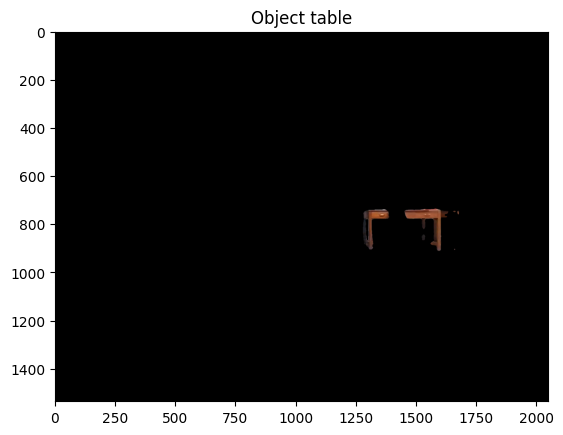

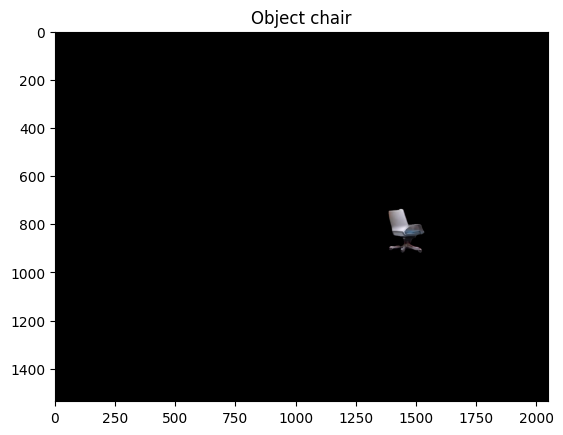

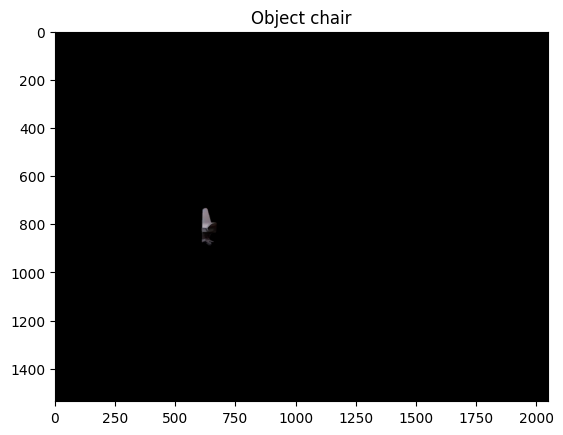

In [30]:
#Code to visualize separate masks for a single image

img_id = '1'

# Load the image
img_path = img_dict[img_id]['img_path']
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Get the object data for the image
objs = img_dict[img_id]['objs']

# Loop through each object in the image
for obj_index, obj_data in objs.items():
    # Get the mask for the object
    mask = obj_data['mask']
    obj_name = obj_data['phrase']

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Apply the mask to the image. This assumes your mask is binary (0s and 1s).
    # If it isn't, you may need to adjust this step accordingly.
    masked_image = img * np.expand_dims(mask, axis=2)

    # Display the masked image
    plt.figure()
    plt.imshow(masked_image)
    plt.title(f"Object {obj_name}")
    plt.show()


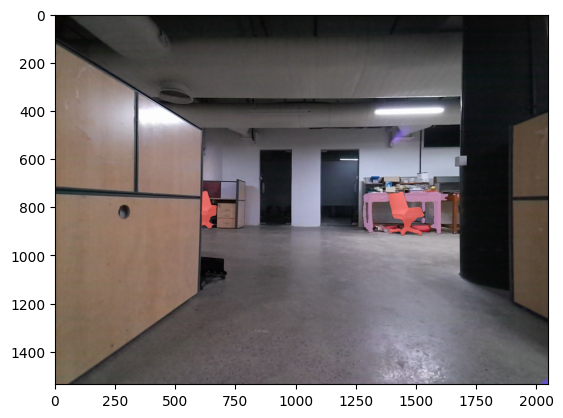

In [31]:
#Code to draw the segmentation mask on the image

from torchvision.utils import draw_segmentation_masks

# Load the image
img_id = '1'
img_path = img_dict[img_id]['img_path']
img = Image.open(img_path)  # Load with PIL to avoid needing to convert color spaces

transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img)
img_tensor = (img_tensor * 255).byte()

masks = []
mask_colors = []

objs = img_dict[img_id]['objs']

for obj_index, obj_data in objs.items():
    mask = obj_data['mask']

    phrase = obj_data['phrase']
    phrase = phrase.split()[0] #Use only the first phrase

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Add the mask to the list of masks
    masks.append(mask)
    #Cheeck the color for the mask and add it to the list
    color = colors[req_tags.index(phrase)]
    mask_colors.append(color)

# Convert the masks to a boolean tensor
masks_tensor = torch.tensor(masks, dtype=torch.bool)

# Draw all masks on the image
result = draw_segmentation_masks(img_tensor, masks_tensor, colors=mask_colors)

# Convert the result tensor back to a PIL image, transpose the dimensions back to H,W,C for PIL
result_img = Image.fromarray(result.permute(1, 2, 0).byte().cpu().numpy())

# Display the image with all masks
plt.imshow(result_img)
plt.show()
